# Learning Notebook - SLU13 - Validation Metrics for Classification


The associated presentation of this Example Notebook can be found [here](https://docs.google.com/presentation/d/1lEE9BUWsUKryXzGCLyysX7d78XL3ylANTU-fMKtIeYE/edit?usp=sharing).

By now you are already a fan of `scikit-learn`. It covers extensively the **validation metrics for classification** (which can mostly found [here](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)). 

The ones presented in this notebook are:
- Accuracy Score
- Confusion Matrix
- Precision
- Recall
- F1-Score
- Area Under the Receiver Operating Charactristic Curve (AUROC)

----
*By: Hugo Lopes  
LDSA - SLU13*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
    
from utils import plot_roc_curve

%matplotlib inline 

# Load some example _probas_
The example data (from binary classification), presented next, contains:
- Column 1: **`scores`** or *probas* (output of `predict_proba()`) in the range [0, 1]
- Column 2: **`target`** or actual outcome (a.k.a., labels)

As a reminder, the scores/probas were obtained by **`classif_model.predic_proba(X)`**, where:
- `classif_model` is a scikit-learn classifier Class (e.g., `LogisticRegression()`)
- `predict_proba(X)` is the method that predicts the class probabilities for `X`

Time to load our `scores` and `probas`:

In [3]:
df_results = pd.read_csv('classifier_prediction_scores.csv')
print('Number of rows:', df_results.shape[0])
df_results.head()

Number of rows: 1250


,scores,target
0,0.288467,0
1,0.255047,1
2,0.201017,0
3,0.729307,1
4,0.148288,0


Let's take a look at the scores distribution - always a good idea as a Exploratory Data Analysis measure. As an output of the `predict_proba()`, the range of the scores is [0, 1].

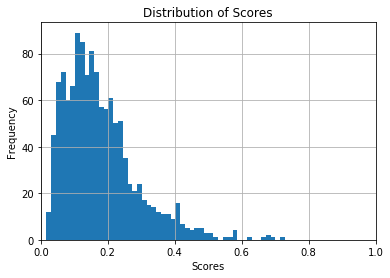

In [4]:
df_results['scores'].hist(bins=50)
plt.ylabel('Frequency')
plt.xlabel('Scores')
plt.title('Distribution of Scores')
plt.xlim(0, 1)
plt.show()

# Classification Metrics
## Accuracy score
The [accuracy_score](http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score) is the fraction (default) or the count (normalize=False) of correct predictions. It is given by:  

$$ A = \frac{TP + TN}{TP + TN + FP + FN} $$

Where, TP is the True Positives, TN the True Negatives, FP the False Positives, and False Negative.

Disavantages:
- Not recommended its use in highly imbalanced datasets.
- You have to set a threshold for the output of the classifiers.

First, you need to specify the threshold above which the predicted label is considered 1, then generate the predicted outcomes:

In [5]:
threshold = 0.50
# Generate the predicted labels (above threshold = 1, below = 0)
predicted_outcome = [0 if k <= threshold else 1 for k in df_results['scores']]

In [6]:
print('Accuracy = %2.3f' % accuracy_score(df_results['target'], predicted_outcome))

Accuracy = 0.830


Well, does not look that bad to have an accuracy of 83%. Let's continue...

## Confusion Matrix
The [confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) *C* provides several performance indicators:
- C(0,0) - TN count
- C(1,0) - FN count
- C(0,1) - FP count
- C(1,1) - TP count

It is one of the most comprehensive ways to represent the result of evaluating binary classification.

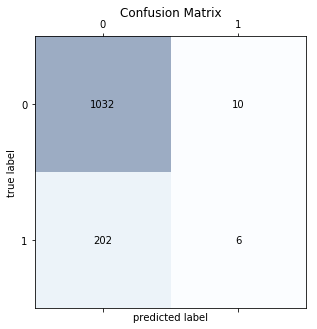

In [7]:
# Get the confusion matrix:
confmat = confusion_matrix(y_true=df_results['target'], y_pred=predicted_outcome)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
        s=confmat[i, j],
        va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')
plt.show()

As can be seen, the number of False Negatives is very high, which, depending on the business could be harmful.

## Precision, Recall and F1-score
- [**Precision**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) is the ability of the classifier not to label as positive a sample that is negative (i.e., a measure of result relevancy).
$$ P = \frac{T_P}{T_P+F_P} $$  
  
  
- [**Recall**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score) is the ability of the classifier to find all the positive samples (i.e., a measure of how many truly relevant results are returned).
$$ R = \frac{T_P}{T_P+F_N} $$  
  
  
- [**F1 score**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) can be interpreted as a weighted harmonic mean of the precision and recall (in this case recall and precision are equally important).
$$ F1 = 2\frac{P \times R}{P+R} $$

where $T_P$ is the true positives, $F_P$ the false positives, and $F_N$ the false negatives. For further information on precision, recall and f1-score click [here](http://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures).

Different metrics serve different purposes. One of the most important issues is related with the balance of our binary classification problem. So, before computing any of the above metrics, let's check if our dataset has **class imbalance**:

In [8]:
df_results['target'].value_counts(normalize=True)

0    0.8336
1    0.1664
Name: target, dtype: float64

Quite imbalanced! Approximately 83% of the labels are 0. If you rely just on accuracy, then, if your classifier is simply dummy and output 0 at all times, you would have a very high 83% accuracy without any additional effort. Imagine a fraud case: the general case is to have 0.1 to 0.01% (or even less) positive (1 = fraud) outcomes. It means in this case you would have 99.9% or 99.99% accuracy - quite impressive right?


![shut up](https://i.imgflip.com/289ows.jpg)

**NOT!**

Let's take a look at the **other metrics more appropriate for this type of (imbalanced) datasets**:

In [9]:
print('Precision score = %1.3f' % precision_score(df_results['target'], predicted_outcome))
print('Recall score = %1.3f' % recall_score(df_results['target'], predicted_outcome))
print('F1 score = %1.3f' % f1_score(df_results['target'], predicted_outcome))

Precision score = 0.375
Recall score = 0.029
F1 score = 0.054


As you can see, the results are not so good from other points of view. 

Time to explore a metric that you will hear a lot, that is much more robust for imbalanced datasets...

## Receiver Operating Characteristic (ROC) and Area Under the ROC curve (AUROC)

The Receiver Operating Characteristic (ROC) curve is a very common (and important) metric for **binary classification problems**. 

**Formally**, it is created by plotting the fraction of true positives out of the positives (TPR = true positive rate, a.k.a., sensitivity) vs. the fraction of false positives out of the negatives (FPR = false positive rate, or 1-specificity), at various threshold settings.  
- The [**`roc_curve`**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) compute Receiver Operating Characteristic (ROC) curve points.
- The [**`roc_auc_score`**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) function computes the Area Under the ROC curve (AUROC). I.e., the curve information is summarized in one number.  

Take a look at an example ROC curve next ([source](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)):
!['ROC'](http://scikit-learn.org/stable/_images/sphx_glr_plot_roc_001.png)

The desired curve is one that gets to top left corner the fastest possible (which as you can imagine maximizes the area below it). So, an ideal AUROC curve (but I would say very suspicious as well) is 1.0, while in a completely random scenario we have an AUROC = 0.5. If you ever get an AUROC below 0.5 then something might be wrong since you are better of by having a random prediction than using your own classifier :)

Unlike the previous metrics, the ROC functions above require the actual scores/probabilities (and not the predicted labels).

## Intuition on ROC curve
Imagine you have the outputs of your classifier, and these outputs are the probabilities of the observations being 1, as shown next:

In [10]:
df_results.sort_values('scores').iloc[4:12]

,scores,target
965,0.026951,0
226,0.027868,0
222,0.028234,0
781,0.029250,0
544,0.029404,0
19,0.029526,1
119,0.030816,0
700,0.030903,0


where `scores` are our probabilities (in range [0, 1]) and we sorted by ascending order. We also have on the second column, the actual out come. What do you think would be the perfect scenario? 

- The perfect scenario would be **all** zeros coming first and **all** ones on the reminder of the data.

This means our binary classifier would be a perfect _discriminator_. Take a look now at the figure below. On the top left we have the distribution of  
!['a'](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/ROC_curves.svg/709px-ROC_curves.svg.png) being 1 and 0. What would it be the ideal case then? To have no overlapping bell curves! 

The vertical line is a threshold: imagine moving it from left to right - it is equivalent of moving the black circle in the ROC curve plot left to right.


## ROC AUC by hand
Let's calculate the FPR (x-axis of the ROC curve) and TPR (y-axis of the ROC curve). This will help us understand how this actually works...

In [11]:
df_results_sorted = df_results.sort_values(by='scores')
df_results_sorted.head()

,scores,target
522,0.016875,0
55,0.019694,0
1167,0.024242,0
245,0.026947,0
965,0.026951,0


In [ ]:
confusion_matrix(df_results.loc[:k, 'target'], 
                                      predicted_outcome[:k+1]).ravel()

In [ ]:
confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

In [ ]:
confusion_matrix(y_true[:k+1], 
                                      predicted_outcome[:k+1])

In [14]:
df_results_sorted.head()

,scores,target
522,0.016875,0
55,0.019694,0
1167,0.024242,0
245,0.026947,0
965,0.026951,0


In [60]:
tpr = []
fpr = []
y_true = df_results['target'].tolist()

for k in range(df_results.shape[0]):
    tn, fp, fn, tp = confusion_matrix(y_true[:k+100], 
                                      predicted_outcome[:k+100]).ravel()

    #tpr.append(tp / (tp + fn))
    #fpr.append(fp / (fp + tn))

    tpr.append(tp / (6 + 202))
    fpr.append(fp / (10 + 1032))

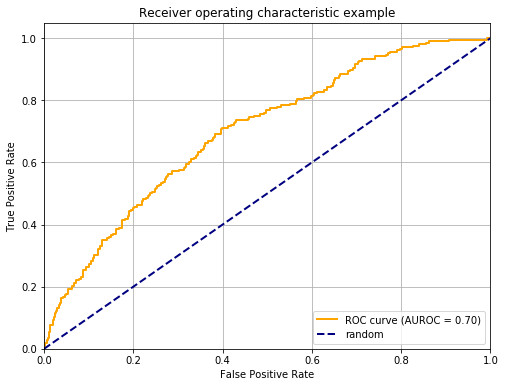

In [11]:
# Data to compute the ROC curve (FPR and TPR):
fpr, tpr, thresholds = roc_curve(df_results['target'], df_results['scores'])
# The Area Under the ROC curve:
roc_auc = roc_auc_score(df_results['target'], df_results['scores'])

plot_roc_curve(roc_auc, fpr, tpr)

As we can see, the AUROC is 0.70. A value of 0.50 means that the classifier is no better than random.